In [0]:
#This cell is for running on the google colab
# !apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
# !ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
# !pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
# !pip install 'cupy-cuda80==4.0.0b4' 'chainer==4.0.0b4'
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id': '1hJ2iRRFyx_prKa7X9W9D8kBPrCIGFPwv'})
downloaded.GetContentFile('data.npz')

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

data=np.load('data.npz')
y=data['labels'][:3000]
X=data['data_1'][:3000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

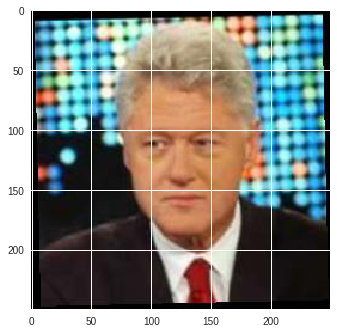

label:0


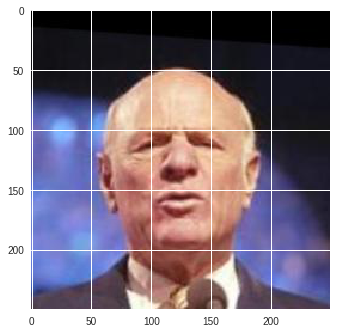

label:0


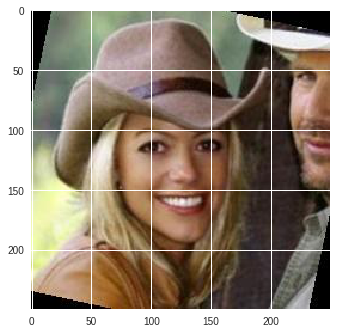

label:1


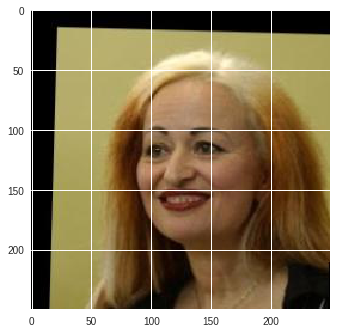

label:1


In [8]:
import matplotlib.pyplot as plt

def showimage(images, index):
  img=images[index].transpose(1,2,0)
  plt.imshow(img)
  plt.show()

for i in [2,3,7,8]:
  showimage(X_train,i)
  print('label:'+str(y_train[i]))

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F

class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=3, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 2)

    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)

In [0]:
import cupy
from chainer.datasets import tuple_dataset
from chainer import cuda, optimizers, training, iterators
from chainer.training import extensions

model = L.Classifier(CNN())
gpu = 0
if gpu == 0:
    xp = cuda.cupy
    cupy.cuda.Device(gpu).use()
    model.to_gpu()
    X_train = cuda.to_gpu(X_train)
    X_test = cuda.to_gpu(X_test)
    y_train = cuda.to_gpu(y_train)
    y_test = cuda.to_gpu(y_test)

optimizer = chainer.optimizers.SGD()
optimizer.setup(model)
batchsize = 100
n_epoch = 20

train = tuple_dataset.TupleDataset(X_train, y_train)
train_iter = iterators.SerialIterator(train, batch_size=batchsize, shuffle=True)
updater = training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out='result')

test = tuple_dataset.TupleDataset(X_test, y_test)
test_iter = iterators.SerialIterator(test, batch_size=batchsize, shuffle=False, repeat=False)

trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'validation/main/accuracy', 'validation/main/loss']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], 'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], 'epoch', file_name='loss.png'))

In [5]:
from chainer import serializers
trainer.run()

if gpu==0:
  model.to_cpu()
serializers.save_npz('face_gender.model', model)

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
1           0.765714       0.559421    0.752222                  0.50988               
2           0.769524       0.487799    0.752222                  0.467503              
3           0.775238       0.447581    0.76                      0.440989              
4           0.796191       0.4201      0.762222                  0.468363              
     total [###########.......................................] 23.81%
this epoch [######################################............] 76.19%
       100 iter, 4 epoch / 20 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
5           0.812381       0.395459    0.8                       0.414754              
6           0.820952       0.383883    0.803333                  0.409622              
7           0.832381       0.371994    0.807778                  0.388123              
8           0.841905       0.351715    0.822222               

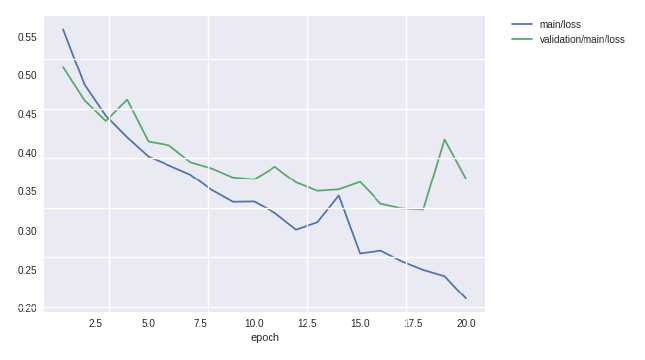

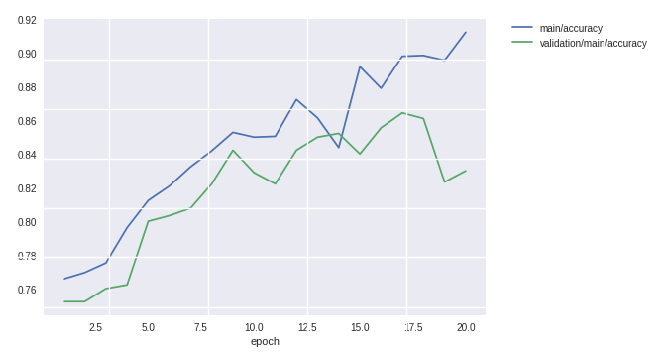

In [15]:
from pylab import box

model = L.Classifier(CNN())
serializers.load_npz('face_gender.model', model)

if gpu==0:
  X_train = cuda.to_cpu(X_train)
  X_test = cuda.to_cpu(X_test)
  y_train = cuda.to_cpu(y_train)
  y_test = cuda.to_cpu(y_test)

def show_graph(src):
    img = plt.imread(src)
    xpixels, ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")
    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

show_graph('result/loss.png')
show_graph('result/accuracy.png')

In [0]:
from sklearn import metrics

def predict(model, X):
    if len(X.shape) == 3:
        pred = model.predictor(X[None, :]).data.argmax()
    else:
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

# print('accuracy: %.3f' % metrics.accuracy_score(y_test, predict(model, X_test)))
# print('recall: %.3f' % metrics.recall_score(y_test, predict(model, X_test), average='macro'))
# print('precision: %.3f' % metrics.precision_score(y_test, predict(model, X_test), average='macro'))
# print('f1_score: %.3f' % metrics.f1_score(y_test, predict(model, X_test), average='macro'))

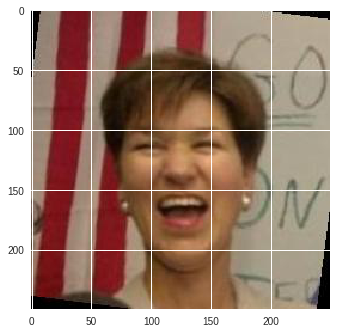

predict:1
True


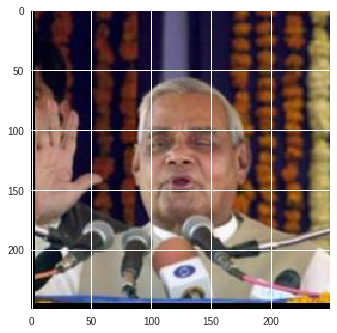

predict:0
True


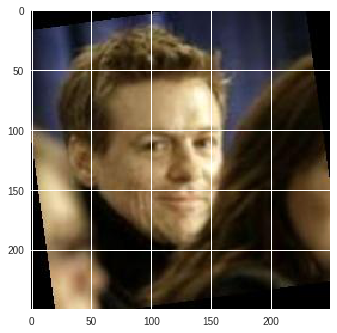

predict:1
False


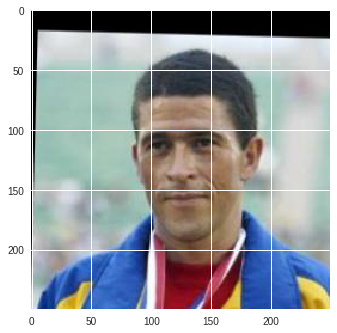

predict:0
True


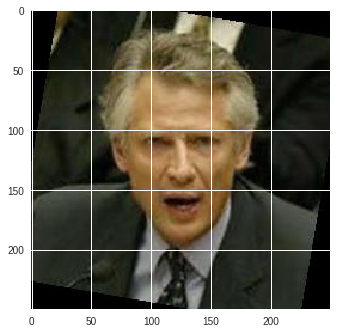

predict:0
True


In [21]:
def judge(index):
#   showimage(X_test, index)
  pred = predict(model, X_test[index])
  print('predict:'+str(pred))
  print(pred == y_test[index])
  return None

for i in range(5):
  showimage(X_test,i)
  judge(i)